In [ ]:
import cv2 as cv
import os
import shutil
import random
import numpy as np
import rasterio
from tqdm import tqdm
from pathlib import Path

In [ ]:
# Define your folders
images_folder = r"archive/test"
masks_folder = r"archive/test"

In [ ]:
def process_and_save_png(image_path, label_path):
    """Reads a raster image, normalizes it, and saves it as a PNG file along with the label."""
    
    # Read the image
    with rasterio.open(image_path) as src:
        # image = np.dstack((src.read(7), src.read(6), src.read(2)))  # Stack bands
        image = np.dstack((src.read(4), src.read(3), src.read(2)))  # Stack bands
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0,1]
        image = (image * 255).astype(np.uint8)  # Convert to uint8 for PNG
    
    # Read the label
    with rasterio.open(label_path) as src:
        label = src.read(1)  # Single-band grayscale
        label = ((label - label.min()) / (label.max() - label.min()) * 255).astype(np.uint8)  # Normalize

    # Save the image
    image_filename = image_path.replace('.tif', '.png').replace('archive', 'vis')
    label_filename = label_path.replace('.tif', '.png').replace('archive', 'vis').replace('RT_v1_', 'RT_voting_')

    os.makedirs(os.path.dirname(image_filename), exist_ok=True)
    os.makedirs(os.path.dirname(label_filename), exist_ok=True)

    cv.imwrite(image_filename, cv.cvtColor(image, cv.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV
    # cv.imwrite(label_filename, label)


In [ ]:
def get_image_path(datapath, type='png', limit=None, seed=1):
    image_paths = [str(path) for path in list(Path(datapath).glob(f'./images/*.{type}'))]
    if limit is not None:
        random.seed(seed)
        random.shuffle(image_paths)
        image_paths= image_paths[:limit]

    return sorted(image_paths)

def get_label_path(image_path):
    split = image_path.rfind('_')
    label_path = f"{image_path[:split]}_v1{image_path[split:]}".replace('images', 'masks')
    
    return label_path

In [ ]:
ds = get_image_path(images_folder, type='png')
ds

In [ ]:
for i in range(len(ds)):
    im, mk = ds[i], get_label_path(ds[i])
    process_and_save_png(im, mk)

analsysis

In [ ]:
import matplotlib.pyplot as plt

# Data for the chart
categories = ["Total Patches",  "Patches with No Fire", "Patches with Fire", "Patches with >5% Fire Pixels"]
values = [150000, 67000, 83000, 9960 ]
colors = ['blue', 'green', 'orange', 'red']  # Different colors for each bar

# Create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(categories)), values, color=colors)

# Add labels and title
plt.ylabel("Number of Image Patches")
# plt.title("Dataset Composition and Fire Pixel Distribution")

# Display values on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 2000, str(v), ha='center', fontsize=10)

# Add a legend
plt.xticks([])  # Remove x-axis labels
plt.legend(bars, categories,  loc='upper right')

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm  # Import tqdm

# Find all mask images
image_files = glob.glob('data/train_val/masks/*.png')
total_images = len(image_files)
count = 0

# Add tqdm for progress tracking
for file_path in tqdm(image_files, desc="Processing images", unit="img"):
    img = Image.open(file_path)
    img_array = np.array(img)
    
    white_pixels = np.sum(img_array == 255)
    total_pixels = 256
    

    
    if (white_pixels / total_pixels) * 100 >= 5:
        count += 1

if total_images == 0:
    print("No images found!")
else:
    percentage = (count / total_images) * 100
    print(f"\nPercentage of images with ≥5% white pixels: {percentage:.4f}%")

Processing images: 100%|██████████| 83805/83805 [02:19<00:00, 601.04img/s] 



Summary Statistics:
Mean percentage of white pixels: 3.6556%
Median percentage of white pixels: 0.7812%
Standard deviation of white pixels: 14.9851%


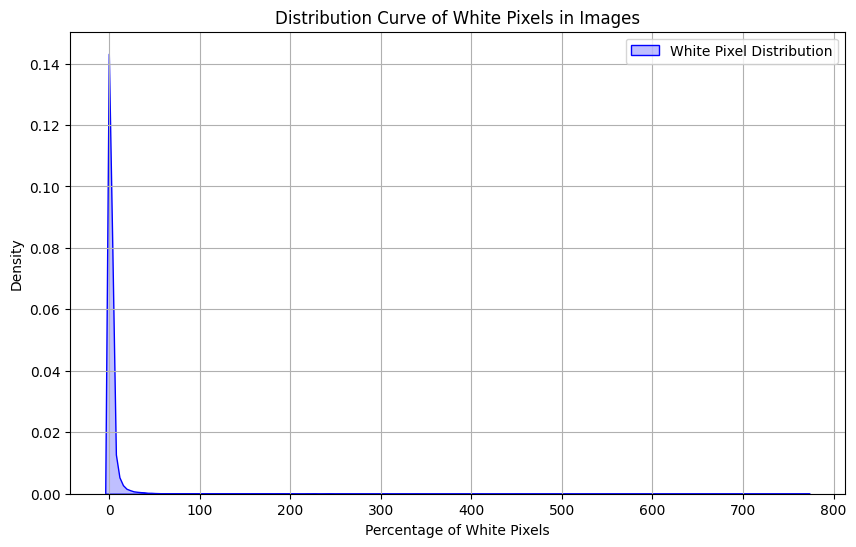

In [ ]:
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns  # For KDE plot

# Find all mask images
image_files = glob.glob('data/train_val/masks/*.png')
total_images = len(image_files)
white_pixel_percentages = []  # Store percentages of white pixels

# Process images with tqdm for progress tracking
for file_path in tqdm(image_files, desc="Processing images", unit="img"):
    img = Image.open(file_path)
    img_array = np.array(img)
    
    white_pixels = np.sum(img_array == 255)
    total_pixels =256
    percentage = (white_pixels / total_pixels) * 100
    white_pixel_percentages.append(percentage)

# Calculate summary statistics
mean_percentage = np.mean(white_pixel_percentages)
median_percentage = np.median(white_pixel_percentages)
std_percentage = np.std(white_pixel_percentages)

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Mean percentage of white pixels: {mean_percentage:.4f}%")
print(f"Median percentage of white pixels: {median_percentage:.4f}%")
print(f"Standard deviation of white pixels: {std_percentage:.4f}%")

# Plot the distribution curve (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(white_pixel_percentages, color='blue', fill=True)
plt.title("Distribution Curve of White Pixels in Images")
plt.xlabel("Percentage of White Pixels")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


Summary Statistics:
Mean percentage of white pixels: 3.6556%
Median percentage of white pixels: 0.7812%
Standard deviation of white pixels: 14.9851%


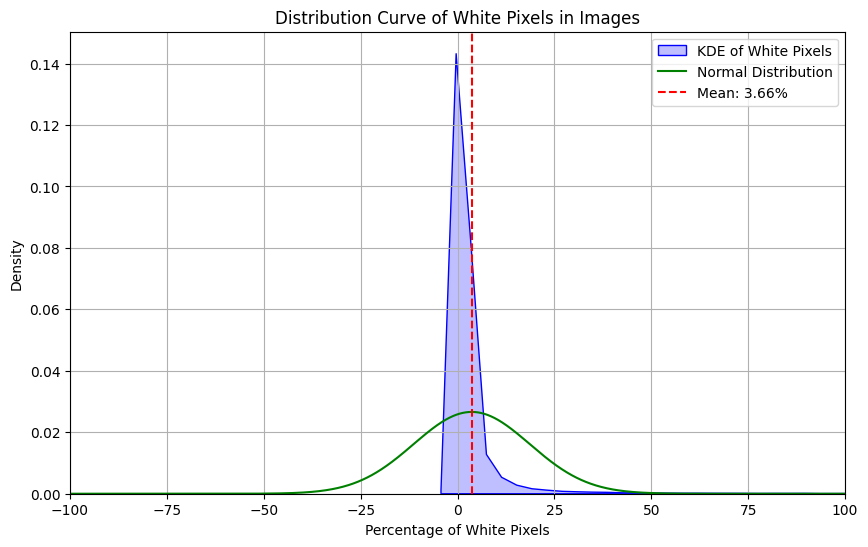

In [12]:
from scipy.stats import norm  # For normal distribution

# Calculate summary statistics
mean_percentage = np.mean(white_pixel_percentages)
median_percentage = np.median(white_pixel_percentages)
std_percentage = np.std(white_pixel_percentages)

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Mean percentage of white pixels: {mean_percentage:.4f}%")
print(f"Median percentage of white pixels: {median_percentage:.4f}%")
print(f"Standard deviation of white pixels: {std_percentage:.4f}%")

# Plot the distribution curve (KDE) from 0 to 100
plt.figure(figsize=(10, 6))
sns.kdeplot(white_pixel_percentages, color='blue', fill=True, label="KDE of White Pixels")

# Generate normal distribution curve
x = np.linspace(-100, 100, 1000)  # Range from 0 to 100
normal_curve = norm.pdf(x, mean_percentage, std_percentage)  # Normal distribution PDF
plt.plot(x, normal_curve, color='green', linestyle='-', label="Normal Distribution")

# Add mean line
plt.axvline(mean_percentage, color='red', linestyle='--', label=f"Mean: {mean_percentage:.2f}%")

# Add plot details
plt.title("Distribution Curve of White Pixels in Images")
plt.xlabel("Percentage of White Pixels")
plt.ylabel("Density")
plt.xlim(-100, 100)  # Set x-axis limits from 0 to 100
plt.legend()
plt.grid(True)
plt.show()